![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

#  Introduction to Text Mining and Natural Language Processing
## Homework 1: Research Project about hotel prices on Booking.com

GROUP 11: Luis Francisco Alvarez Poli, Vanessa Kromm, Clarice Mottet

In [1]:
import json
import numpy as np
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException, StaleElementReferenceException
from selenium import webdriver
import os
from bs4 import BeautifulSoup
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
import requests
import re
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

path_in_ = r'C:\Users\clari\OneDrive\Desktop\VSCode\Term2_IntroLanguage\homework1\github_repo\Booking_Scraping'
path_out_ = r'C:\Users\clari\OneDrive\Desktop\VSCode\Term2_IntroLanguage\homework1\outputs'
path_out_reg_ = r'C:\Users\clari\OneDrive\Desktop\VSCode\Term2_IntroLanguage\homework1\github_repo\Booking_Scraping\data_for_regression'


## Scraping of the data

In [2]:
def ffx_preferences(dfolder, download=False):
    '''
    Sets the preferences of the firefox browser: download path.
    '''
    profile = webdriver.FirefoxProfile()
    # set download folder:
    profile.set_preference("browser.download.dir", dfolder)
    profile.set_preference("browser.download.folderList", 2)
    profile.set_preference("browser.download.manager.showWhenStarting", False)
    profile.set_preference("browser.helperApps.neverAsk.saveToDisk",
                           "application/msword,application/rtf, application/csv,text/csv,image/png ,image/jpeg, application/pdf, text/html,text/plain,application/octet-stream")


    # this allows to download pdfs automatically
    if download:
        profile.set_preference("browser.helperApps.neverAsk.saveToDisk", "application/pdf,application/x-pdf")
        profile.set_preference("pdfjs.disabled", True)

    options = Options()
    options.profile = profile
    return options


def start_up(link, dfolder, geko_path, firefox_binary_path, download=True):
    os.makedirs(dfolder, exist_ok=True)

    options = ffx_preferences(dfolder, download)
    options.binary_location = firefox_binary_path  # Set Firefox binary location
    service = Service(geko_path)
    browser = webdriver.Firefox(service=service, options=options)
    
    # Enter the website address here
    browser.get(link)
    
    time.sleep(5)  
    return browser


def check_and_click(browser, xpath, type):
    '''
    Function that checks whether the object is clickable and, if so, clicks on
    it. If not, waits one second and tries again.
    '''
    ck = False
    ss = 0
    while ck == False:
        ck = check_obscures(browser, xpath, type)
        time.sleep(1)
        ss += 1
        if ss == 15:
            # warn_sound()
            # return NoSuchElementException
            ck = True
            # browser.quit()

def check_obscures(browser, xpath, type):
    '''
    Function that checks whether the object is being "obscured" by any element so
    that it is not clickable. Important: if True, the object is going to be clicked!
    '''
    try:
        if type == "xpath":
            browser.find_element('xpath',xpath).click()
        elif type == "id":
            browser.find_element('id',xpath).click()
        elif type == "css":
            browser.find_element('css selector',xpath).click()
        elif type == "class":
            browser.find_element('class name',xpath).click()
        elif type == "link":
            browser.find_element('link text',xpath).click()
    except (ElementClickInterceptedException, NoSuchElementException, StaleElementReferenceException) as e:
        print(e)
        return False
    return True

In [4]:
# lets open booking:

dfolder='C:/Users/vanes/Downloads'
geko_path='C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/TA-Sessions/geckodriver.exe'
link='https://www.booking.com/index.html?lang=en'
firefox_binary_path = r'C:\Program Files\Mozilla Firefox\firefox.exe'  


browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path, firefox_binary_path=firefox_binary_path)

#### close cookies pop-up

In [5]:
browser.find_element(by='xpath',value='//*[@id="onetrust-accept-btn-handler"]').click()

### Input the place and dates

#### Since more than 1 place and more than 1 week has to be looked at, a function is defined to impute the place and the dates

In [9]:
# input the place
def input_place(place):
    browser.find_element(by='xpath',value='//*[@id=":re:"]').click()
    search1 = browser.find_element(by='xpath',value='//*[@id=":re:"]')
    search1.send_keys(place)


In [8]:
# input the dates
def input_dates(from_day, to_day, change_month = 0):
    css='button.ebbedaf8ac:nth-child(2) > span:nth-child(1)'

    browser.find_element('css selector',css).click()

    # click to change the month to May/June (only necessary for the first imnsertion of dates)
    if change_month == 1:
        browser.find_element(By.XPATH, '/html/body/div[3]/div[2]/div/form/div[1]/div[2]/div/div[2]/div/nav/div[2]/div/div[1]/button/span/span').click()
        browser.find_element(By.XPATH, '/html/body/div[3]/div[2]/div/form/div[1]/div[2]/div/div[2]/div/nav/div[2]/div/div[1]/button[2]').click()
        browser.find_element(By.XPATH, '/html/body/div[3]/div[2]/div/form/div[1]/div[2]/div/div[2]/div/nav/div[2]/div/div[1]/button[2]').click()

    path = '//div[@id="calendar-searchboxdatepicker"]//table[@class="eb03f3f27f"]//tbody//td[@class="b80d5adb18"]//span[@class="cf06f772fa"]'

    dates = browser.find_elements('xpath', path)

    for date in dates:
        date_value = date.get_attribute("data-date")
        
        if date_value == from_day:
            date.click()
        elif date_value == to_day:
            date.click()
            break

### Iterate through all pages and hotels to extract the information

In [10]:
# find total number of pages
def get_number_pages(browser):
    '''
    Get the number of pages. 
    '''
    a = browser.find_elements('xpath',
        '/html/body/div[4]/div/div[2]/div/div[2]/div[3]/div[2]/div[2]/div[4]/div[2]/nav/nav/div/div[2]/ol/li[7]/button')
    return(int(a[-1].text))


In [11]:
css_pages = 'div.b16a89683f:nth-child(3) > button:nth-child(1) > span:nth-child(1) > span:nth-child(1)'
def get_information(pages):
    # initialize lists
    hotel_names = []
    ratings = []
    room_descriptions = []
    prices = []
    location_descriptions = []
    hotel_links = []

    sections = browser.find_elements('xpath', '//div[@class="c066246e13"]')
    for hotel in sections:
        hotel_name = hotel.find_element('xpath', './/div[@class="f6431b446c a15b38c233"]').text

    for page in range(int(pages)+1):    
        #Print page that it is in 
        print(f'Page: {page + 1}')
        sections = browser.find_elements('xpath', '//div[@class="c066246e13"]')
        for hotel in sections:
            # extract hotel name
            hotel_name = hotel.find_element('xpath', './/div[@class="f6431b446c a15b38c233"]').text
            hotel_names.append(hotel_name)
            # extract ratings
            try:
                rating = hotel.find_element('xpath', './/div[@class="a3b8729ab1 d86cee9b25"]').text
            except:
                rating = np.nan
            ratings.append(rating)    
            # extract prices
            try:
                price = hotel.find_element('xpath','.//span[@class="f6431b446c fbfd7c1165 e84eb96b1f"]').text
            except:
                price = np.nan
            prices.append(price) 
            # extract room_descriptions
            try:
                room_description = hotel.find_element('xpath','.//div[@class="c19beea015"]').text
            except:
                room_description = np.nan
            room_descriptions.append(room_description)
            # extract location_descriptsion
            try:
                location_description = hotel.find_element('xpath', './/div[@class="abf093bdfe ecc6a9ed89"]').text
            except:
                location_description = np.nan  
            location_descriptions.append(location_description)
            # get links of all hotels
            try:
                hotel_link = hotel.find_element('xpath', './/a[@class="a78ca197d0"]').get_attribute('href')
            except:
                hotel_link = np.nan  
            hotel_links.append(hotel_link)

        next_page = browser.find_element('css selector', css_pages).click()
        # add sleep time to avoid that a page is scraped twice due to a slow wifi
        time.sleep(2)        
       

    df = pd.DataFrame({'hotel_name': hotel_names, 'rating': ratings, 'room_description': room_descriptions, 'price': prices, 'location_descirption': location_descriptions, 'hotel_link': hotel_links})
    return df

### Look at hotels in Barcelona during Primavera Sound

In [12]:
input_place('Barcelona')
input_dates('2024-05-27', '2024-06-02', 1)
# click on "search"
my_xpath='/html/body/div[3]/div[2]/div/form/div[1]/div[4]/button/span'
check_and_click(browser,my_xpath , type='xpath')    

In [14]:
# close "Genius Pop up"
browser.find_element(By.XPATH, '/html/body/div[51]/div/div/div/div[1]/div[1]/div/button/span/span').click()

In [41]:
pages = get_number_pages(browser)
barcelona_treatment = get_information(pages)

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40


In [42]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to extract text from a given URL using BeautifulSoup and XPath-like expression
def extract_text_from_url(url, expression):
    # Fetch the HTML content
    response = requests.get(url)
    html_content = response.content

    # Parse HTML with BeautifulSoup using 'lxml' parser
    soup = BeautifulSoup(html_content, 'lxml')

    # Use a CSS selector to find the desired element
    element = soup.select_one(expression)

    # Extract text from the found element
    if element:
        return element.get_text(strip=True)
    else:
        return None


# XPath-like expression for the element you want to extract
expression_to_extract = '#summary'

# Extract text from each URL in the DataFrame and store in a new column
barcelona_treatment['long_description'] = barcelona_treatment['hotel_link'].apply(lambda url: extract_text_from_url(url, expression_to_extract))


In [44]:
# Save dataframe as csv to work with it later
barcelona_treatment.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/barcelona_treatment.csv')

### now we have to change the date to extract the hotel prices for the week before the event

We only scrape the name and the price here because rating and description will not change.

In [45]:
css_pages = 'div.b16a89683f:nth-child(3) > button:nth-child(1) > span:nth-child(1) > span:nth-child(1)'
def get_only_prices(pages):
    hotel_names = []
    prices_week_before = []
    
    sections = browser.find_elements('xpath', '//div[@class="c066246e13"]')
    for hotel in sections:
        hotel_name = hotel.find_element('xpath', './/div[@class="f6431b446c a15b38c233"]').text

    for page in range(int(pages)+1):        
        #Print page that it is in 
        print(f'Page: {page + 1}')
        sections = browser.find_elements('xpath', '//div[@class="c066246e13"]')
        for hotel in sections:
            hotel_name = hotel.find_element('xpath', './/div[@class="f6431b446c a15b38c233"]').text
            hotel_names.append(hotel_name)  
            # extract prices
            try:
                price_week_before = hotel.find_element('xpath','.//span[@class="f6431b446c fbfd7c1165 e84eb96b1f"]').text
            except:
                price_week_before = np.nan
            prices_week_before.append(price_week_before)

        next_page = browser.find_element('css selector', css_pages).click()
        time.sleep(2)        

    df = pd.DataFrame({'hotel_name': hotel_names, 'price_week_before': prices_week_before})
    return df

In [46]:
input_dates('2024-05-20', '2024-05-26')
# click on "search"
my_xpath='/html/body/div[4]/div/div[2]/div/div[1]/div/form/div[1]/div[4]/button/span'
check_and_click(browser,my_xpath , type='xpath') 
pages = get_number_pages(browser)
barcelona_control = get_only_prices(pages)

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41


In [49]:
# Save dataframe as csv to work with it later
barcelona_control.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/barcelona_control.csv')

Creating a dataframe that contains prices for both weeks

In [51]:
barcelona_merged = pd.merge(barcelona_treatment, barcelona_control, on='hotel_name', how='left')

barcelona_merged = barcelona_merged.dropna(subset=['price_week_before'])


In [53]:
# Save dataframe as csv to work with it later
barcelona_merged.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/barcelona_merged.csv')

### now we have to change the city to extract the hotel prices for the week before the event for Rome

In [54]:
# clear the field first
browser.find_element(by='xpath',value='//*[@id=":re:"]').clear()
input_place('Rome')
time.sleep(3)
# here we have to click on the second entry for Rome, the first one is only the city centre
browser.find_element(by='xpath',value='//*[@id="autocomplete-result-1"]').click()
# add sleep time, because otherwise it will still show results for Barcelona
time.sleep(3)
# click on "search"
my_xpath='/html/body/div[4]/div/div[2]/div/div[1]/div/form/div[1]/div[4]/button/span'
check_and_click(browser,my_xpath , type='xpath') 
pages = get_number_pages(browser)
rome_control = get_only_prices(pages)

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41


In [55]:
# Save dataframe as csv to work with it later
rome_control.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/rome_control.csv')

### extract prices and all the information for Rome during the week of event

In [57]:
input_dates('2024-05-27', '2024-06-02')
my_xpath='/html/body/div[4]/div/div[2]/div/div[1]/div/form/div[1]/div[4]/button/span'
check_and_click(browser,my_xpath , type='xpath') 
pages = get_number_pages(browser)
rome_treatment = get_information(pages)

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41


In [58]:
# Extract text from each URL in the DataFrame and store in a new column
rome_treatment['long_description'] = rome_treatment['hotel_link'].apply(lambda url: extract_text_from_url(url, expression_to_extract))

In [60]:
# Save dataframe as csv to work with it later
rome_treatment.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/rome_treatment.csv')

In [62]:
rome_merged = pd.merge(rome_treatment, rome_control, on='hotel_name', how='left')

rome_merged = rome_merged.dropna(subset=['price_week_before'])


In [64]:
# Save dataframe as csv to work with it later
rome_merged.to_csv('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/rome_merged.csv')

## Feature extraction for regression

In [29]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

def pipeline_DTM(filepath, column_name):
    # Load csv file
    df = pd.read_csv(filepath)

    tokenized_texts = []
    # Iterate through the 'text' column and save each sentence as a string
    for index, row in df.iterrows():
        tokens = nltk.word_tokenize(str(row[column_name]))
        tokenized_texts.append(tokens)

    # lowercasing, stopword removal, and stemming
    corpus_stop = []
    corpus_stem = []
    for words in tokenized_texts:
        lowered_removed_stopwords = [abbr_or_lower(strip(w)) for w in words if
                                     abbr_or_lower(strip(w)) not in stopwords.words('english')]
        #print(lowered_removed_stopwords)
        corpus_stop.append(lowered_removed_stopwords)
        stemmed = [SnowballStemmer("english").stem(w) for w in lowered_removed_stopwords]
        # print(stemmed)
        corpus_stem.append(" ".join(stemmed))

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), norm=None, min_df=0.05, max_df=0.8)
    tfidf_vectorized_text = tfidf.fit_transform(corpus_stem)
    tfidf_vectorized_text = tfidf_vectorized_text.todense()

    # Creating a DataFrame from the TF-IDF vectorized data
    df_tfidf_vectorized = pd.DataFrame(tfidf_vectorized_text, columns=tfidf.get_feature_names_out())

    return df_tfidf_vectorized


In [31]:
df_tfidf_barcelona = pipeline_DTM('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/barcelona_merged.csv','long_description')

In [32]:
# Sum the TF-IDF scores for each term across all documents
term_scores = df_tfidf_barcelona.sum(axis=0)

# Convert the result to a DataFrame for better visualization
df_term_scores = pd.DataFrame({'Term': term_scores.index, 'TF-IDF Score': term_scores.values})

# Sort the DataFrame by TF-IDF score in descending order
df_term_scores = df_term_scores.sort_values(by='TF-IDF Score', ascending=False)

# Display the top N terms
top_terms = 30  # Set the number of top terms you want to display
print(f"Top {top_terms} Terms:")
print(df_term_scores.head(top_terms))

Top 30 Terms:
           Term  TF-IDF Score
53        apart   2392.482131
218       hotel   1917.729335
232          km   1840.066413
356        room   1502.052565
443        walk   1306.909416
137          de   1212.064499
275       minut   1147.169977
335    properti   1105.033135
294       offer   1083.719552
268        metr   1052.143558
45      airport   1009.634432
65         away   1000.456467
409     station    907.704223
204      gracia    901.986313
178      featur    883.366006
276  minut walk    863.438119
346      rambla    854.109360
271       metro    847.177884
255       locat    829.343916
312     passeig    827.088091
313  passeig de    821.101100
49         also    807.894581
223      includ    802.770514
139   de gracia    798.483348
332      privat    784.637174
207       guest    784.132388
62        avail    758.880555
436          tv    748.923674
112   catalunya    748.894302
241          la    735.533069


In [ ]:
df_tfidf_rome = pipeline_DTM('C:/Users/vanes/Desktop/BSE/Term 2/Introduction to Text Mining and NLP/HW1/rome_merged.csv','long_description')

In [34]:
# Sum the TF-IDF scores for each term across all documents
term_scores = df_tfidf_rome.sum(axis=0)

# Convert the result to a DataFrame for better visualization
df_term_scores = pd.DataFrame({'Term': term_scores.index, 'TF-IDF Score': term_scores.values})

# Sort the DataFrame by TF-IDF score in descending order
df_term_scores = df_term_scores.sort_values(by='TF-IDF Score', ascending=False)

# Display the top N terms
top_terms = 30  # Set the number of top terms you want to display
print(f"Top {top_terms} Terms:")
print(df_term_scores.head(top_terms))

Top 30 Terms:
              Term  TF-IDF Score
82           apart   1461.057981
455        station   1215.483977
313          metro   1138.358513
314  metro station   1120.837404
230          guest    902.429786
242           hous    793.341121
232     guest hous    702.826189
405           room    643.037562
504        vatican    638.900716
498           unit    614.554566
56        accommod    613.812590
206         featur    579.312155
308           metr    576.873020
373         privat    511.857635
350          peter    495.312414
115            bed    487.447249
353         piazza    485.288810
197          equip    476.463154
241           home    475.625199
453             st    475.099907
454       st peter    472.683906
92            area    472.163969
384         provid    465.863637
248         includ    463.589094
101           away    456.644231
215     flatscreen    439.265467
216  flatscreen tv    438.995257
397           roma    438.269370
98           avail    437.006

Based on DTM no relevant feature can be extracted from the long descriptions of the hotels

#### Cleaning the data scraped to prepare it for regression analysis.



In [3]:
#path to retrieve the data pulled in

os.listdir(path_in_)

dict_import = {}
list_import = []
for file in os.listdir(path_in_):
    if 'csv' in file:
        file_str = file[:-4]
        dict_import[file_str] = pd.read_csv(path_in_ + '\\' + file, dtype = 'str')
        dict_import[file_str].columns = dict_import[file_str].columns.str.strip().str.lower().str.replace(' ','_')
        dict_import[file_str] = dict_import[file_str].apply(lambda x: x.str.strip())
        dict_import[file_str].drop(columns = ['unnamed:_0'], inplace = True)
        dict_import[file_str]['file_source'] = file
        list_import.append(dict_import[file_str])
        print(file_str+'--------')
        print(dict_import[file_str].columns)

df_all = pd.concat(list_import, ignore_index = True)
df_all.to_excel(path_out_ + '\\' + 'df_all_data.xlsx')

#removing these because I'll clean things first before the merge
del dict_import['barcelona_merged']
del dict_import['rome_merged']


barcelona_control--------
Index(['hotel_name', 'price_week_before', 'file_source'], dtype='object')
barcelona_merged--------
Index(['hotel_name', 'rating', 'room_description', 'price',
       'location_descirption', 'hotel_link', 'long_description',
       'price_week_before', 'file_source'],
      dtype='object')
barcelona_treatment--------
Index(['hotel_name', 'rating', 'room_description', 'price',
       'location_descirption', 'hotel_link', 'long_description',
       'file_source'],
      dtype='object')
rome_control--------
Index(['hotel_name', 'price_week_before', 'file_source'], dtype='object')
rome_merged--------
Index(['hotel_name', 'rating', 'room_description', 'price',
       'location_descirption', 'hotel_link', 'long_description',
       'price_week_before', 'file_source'],
      dtype='object')
rome_treatment--------
Index(['hotel_name', 'rating', 'room_description', 'price',
       'location_descirption', 'hotel_link', 'long_description',
       'file_source'],
      dty

In [5]:
#make copy of raw imports
df_b_control = dict_import['barcelona_control'].copy()
df_b_treat = dict_import['barcelona_treatment'].copy()
df_r_control = dict_import['rome_control'].copy()
df_r_treat = dict_import['rome_treatment'].copy()

#add in city field
df_b_control['city'] = 'barcelona'
df_b_treat['city'] = 'barcelona'
df_r_control['city'] = 'rome'
df_r_treat['city'] = 'rome'

#append control and treatment together for consistent cleaning practices
df_control = pd.concat([df_b_control, df_r_control], ignore_index = True)
df_treat = pd.concat([df_b_treat, df_r_treat], ignore_index = True)
df_control.reset_index(drop = True, inplace = True)
df_treat.reset_index(drop = True, inplace = True)

#remove duplicates

#first by hotel_link
df_treat.drop_duplicates(subset = ['hotel_link'], inplace = True)
#then by hotel_name and price
df_treat.drop_duplicates(subset = ['hotel_name','price'], inplace = True)

#if a hotel has the same name and same room description but different prices
#remove from the data as price is not consistent for same room
df_treat['count'] = 1
df_treat['count'] = df_treat.groupby(by = ['hotel_name','room_description'])['count'].transform('sum')
df_treat = df_treat[df_treat['count']==1]
df_treat.drop(columns = ['count'], inplace = True)

#reset index after removing duplicates
df_control.reset_index(drop = True, inplace = True)
df_treat.reset_index(drop = True, inplace = True)

# df_control.to_excel(path_out_+'\\'+'df_control.xlsx', index = False)
# df_treat.to_excel(path_out_+'\\'+'df_treat.xlsx', index = False)

#convert ratings and price to numeric
df_control['price_week_before'] = df_control['price_week_before'].str.replace('€','').str.replace(',','').str.strip()
df_control['price_week_before'] = pd.to_numeric(df_control['price_week_before'])

df_treat['price'] = df_treat['price'].str.replace('€','').str.replace(',','').str.strip()
df_treat['price'] = pd.to_numeric(df_treat['price'])

df_treat['rating'] = pd.to_numeric(df_treat['rating'])




In [6]:
# use distance from city centre as feature

def calc_dist_city_centre(df):

    # def extract_distance_city_centre(df):    
    pattern = r'(\d?\.?\d,?\d*?\s\w+)'

    # Apply the regex pattern to the 'location' column and create a new 'distance' column
    df['distance_city_centre'] = df['location_descirption'].str.extract(pattern)

    # regex patterns to capture kilometers and meters
    pattern_km = r'(\d?\.?\d,?\d*?)\s?km'
    pattern_m = r'(\d+)\s?m'

    # Apply the regex patterns to the 'distance' column and create new 'distance_meter' and 'distance_meter_only' columns
    df['distance_city_centre_meter'] = df['distance_city_centre'].str.extract(pattern_km)
    df['distance_city_centre_meter_only'] = df['distance_city_centre'].str.extract(pattern_m)

    # Convert the 'distance_city_centre_meter' column to meters (assuming 1 km = 1000 meters)
    df['distance_city_centre_meter'] = pd.to_numeric(df['distance_city_centre_meter'])
    df['distance_city_centre_meter'] = df['distance_city_centre_meter']*1000

    # Replace NaN values in 'distance_city_centre_meter' with values from 'distance_city_centre_meter_only'
    df['distance_city_centre_meter_only'] = pd.to_numeric(df['distance_city_centre_meter_only'])
    df['distance_city_centre_meter'].fillna(df['distance_city_centre_meter_only'], inplace=True)

    # Drop the 'distance_city_centre_meter_only' column
    df.drop(columns=['distance_city_centre_meter_only'], inplace=True)
    df.drop('distance_city_centre', axis=1, inplace = True)
    return df

df_treat = calc_dist_city_centre(df_treat)


In [7]:
def common_terms_cleaning_map(str_):
    #function created to condense terms that are similar

    #assume no cleaning unless otherwise
    str_clean = str_

    #common terms cleaning
    if str_.find('left_at_this_price') > -1:
        str_clean = 'few_left_at_this_price'
    return str_clean

In [8]:
#This code was written formulaically in excel based on 12 bed descriptions that needed special
#attention, it tooks less than 2 minutes to complete even though it seems long

def manual_beds(df_beds):

    #manual code written in excel
    df_beds.loc[df_beds['description']=='multiple_bed_types','extract_number_of_beds'] = 0
    df_beds.loc[df_beds['description']=='2_beds_(1_double,_1_large_double)','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='double_room_with_extra_bed','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='economy_double_sofa_bed','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='small_double_room_with_french_bed','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='6-bed_mixed_dormitory_room','extract_number_of_beds'] = 6
    df_beds.loc[df_beds['description']=='deluxe_double_room_with_extra_bed','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='double_or_twin_room_with_extra_bed','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='double_room_with_french_bed','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='double_room_with_queen_bed_-_basement','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='quadruple_bedbunks_room_with_bathroom','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='standard_triple_room_with_one_double_bed_and_one_single_bed_-_non-smoking','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='superior_double_or_twin_room_with_extra_bed_(2_adults_+_1_child)','extract_number_of_beds'] = 2
    df_beds.loc[df_beds['description']=='twin_room_with_bunk_beds_and_shared_bathroom','extract_number_of_beds'] = 1
    df_beds.loc[df_beds['description']=='multiple_bed_types','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='2_beds_(1_double,_1_large_double)','number_of_double_beds'] = 2
    df_beds.loc[df_beds['description']=='double_room_with_extra_bed','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='economy_double_sofa_bed','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='small_double_room_with_french_bed','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='6-bed_mixed_dormitory_room','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='deluxe_double_room_with_extra_bed','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='double_or_twin_room_with_extra_bed','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='double_room_with_french_bed','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='double_room_with_queen_bed_-_basement','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='quadruple_bedbunks_room_with_bathroom','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='standard_triple_room_with_one_double_bed_and_one_single_bed_-_non-smoking','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='superior_double_or_twin_room_with_extra_bed_(2_adults_+_1_child)','number_of_double_beds'] = 1
    df_beds.loc[df_beds['description']=='twin_room_with_bunk_beds_and_shared_bathroom','number_of_double_beds'] = 0
    df_beds.loc[df_beds['description']=='multiple_bed_types','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='2_beds_(1_double,_1_large_double)','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_extra_bed','number_of_single_beds'] = 1
    df_beds.loc[df_beds['description']=='economy_double_sofa_bed','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='small_double_room_with_french_bed','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='6-bed_mixed_dormitory_room','number_of_single_beds'] = 6
    df_beds.loc[df_beds['description']=='deluxe_double_room_with_extra_bed','number_of_single_beds'] = 2
    df_beds.loc[df_beds['description']=='double_or_twin_room_with_extra_bed','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_french_bed','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_queen_bed_-_basement','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='quadruple_bedbunks_room_with_bathroom','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='standard_triple_room_with_one_double_bed_and_one_single_bed_-_non-smoking','number_of_single_beds'] = 1
    df_beds.loc[df_beds['description']=='superior_double_or_twin_room_with_extra_bed_(2_adults_+_1_child)','number_of_single_beds'] = 1
    df_beds.loc[df_beds['description']=='twin_room_with_bunk_beds_and_shared_bathroom','number_of_single_beds'] = 0
    df_beds.loc[df_beds['description']=='multiple_bed_types','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='2_beds_(1_double,_1_large_double)','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_extra_bed','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='economy_double_sofa_bed','number_of_sofa_beds'] = 1
    df_beds.loc[df_beds['description']=='small_double_room_with_french_bed','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='6-bed_mixed_dormitory_room','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='deluxe_double_room_with_extra_bed','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='double_or_twin_room_with_extra_bed','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_french_bed','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_queen_bed_-_basement','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='quadruple_bedbunks_room_with_bathroom','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='standard_triple_room_with_one_double_bed_and_one_single_bed_-_non-smoking','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='superior_double_or_twin_room_with_extra_bed_(2_adults_+_1_child)','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='twin_room_with_bunk_beds_and_shared_bathroom','number_of_sofa_beds'] = 0
    df_beds.loc[df_beds['description']=='multiple_bed_types','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='2_beds_(1_double,_1_large_double)','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_extra_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='economy_double_sofa_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='small_double_room_with_french_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='6-bed_mixed_dormitory_room','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='deluxe_double_room_with_extra_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='double_or_twin_room_with_extra_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_french_bed','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='double_room_with_queen_bed_-_basement','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='quadruple_bedbunks_room_with_bathroom','number_of_bunk_beds'] = 2
    df_beds.loc[df_beds['description']=='standard_triple_room_with_one_double_bed_and_one_single_bed_-_non-smoking','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='superior_double_or_twin_room_with_extra_bed_(2_adults_+_1_child)','number_of_bunk_beds'] = 0
    df_beds.loc[df_beds['description']=='twin_room_with_bunk_beds_and_shared_bathroom','number_of_bunk_beds'] = 1
    return df_beds

In [9]:
#extract the bed counts

def extract_bed_counts(df_beds):

    for i in range(len(df_beds['description'])):

        #extract_number_of_beds
        list_bed = [r"(\d+)\s*_beds"]
        for extract_bed_regex in list_bed:
            if re.findall(extract_bed_regex, df_beds.loc[i,'description']):
                beds = int(re.findall(extract_bed_regex, df_beds.loc[i,'description'])[0])
                df_beds.loc[i, 'extract_number_of_beds'] = beds

        #extract number of double beds
        list_double_bed = [r"(\d+)\s*_(large_)?double_bed",r"(\d+)\s*_extra-large_double",r"(\d+)\s*_doubles\b",r"(\d+)\s*_large_double\b",r"(\d+)\s*_double\b",r"(\d+)\s*_large_doubles\b"]
        for double_bed_regex in list_double_bed:
            if re.findall(double_bed_regex, df_beds.loc[i,'description']):
                beds = int(re.findall(double_bed_regex, df_beds.loc[i,'description'])[0][0])
                df_beds.loc[i, 'number_of_double_beds'] += beds

        #extract number of single beds
        list_single_bed = [r"(\d+)\s*_single"]
        for single_bed_regex in list_single_bed:
            if re.findall(single_bed_regex, df_beds.loc[i,'description']):
                beds = int(re.findall(single_bed_regex, df_beds.loc[i,'description'])[0])
                df_beds.loc[i, 'number_of_single_beds'] = beds

        #extract number of sofa beds
        list_sofa = [r"(\d+)\s*_sofa_bed",r"(\d+)\s*_futon"]
        for sofa_bed_regex in list_sofa:
            if re.findall(sofa_bed_regex, df_beds.loc[i,'description']):
                beds = int(re.findall(sofa_bed_regex, df_beds.loc[i,'description'])[0][0])
                df_beds.loc[i, 'number_of_sofa_beds'] += beds

        #extract number of bunk beds
        list_bunk_bed = [r"(\d+)\s*_bunk_bed"]
        for bunk_bed_regex in list_bunk_bed:
            if re.findall(bunk_bed_regex, df_beds.loc[i,'description']):
                beds = int(re.findall(bunk_bed_regex, df_beds.loc[i,'description'])[0][0])
                df_beds.loc[i, 'number_of_bunk_beds'] = beds

    return df_beds


In [10]:
#define and extract characteristics by the below
#string split by \n
#string split by '•'

#extract distinct characteristics
list_room_desc = []
for i in range(len(df_treat['hotel_name'])):
    list_split_line = df_treat.loc[i,'room_description'].split('\n')
    for str_ in list_split_line:
        #dot condition
        if '•' in str_:
            list_split_dot = str_.split('•')
            for str_dot in list_split_dot:
                str_dot = str_dot.strip().lower().replace(' ','_')
                str_ = common_terms_cleaning_map(str_)
                list_room_desc.append(str_dot)
        else:
            str_ = str_.strip().lower().replace(' ','_')
            str_ = common_terms_cleaning_map(str_)
            list_room_desc.append(str_)

df_room = pd.DataFrame(list_room_desc, columns = ['description'])
df_room['freq'] = 1
df_room['freq'] = df_room.groupby(by = ['description'])['freq'].transform('sum')
df_room.drop_duplicates(subset = ['description'], inplace = True)
df_room.sort_values(by = ['freq','description'], ascending = [False, True], inplace = True)
df_room.reset_index(drop = True, inplace = True)

df_room['bed'] = 0

for i in range(len(df_room['freq'])):
    str_ = df_room.loc[i, 'description']
    if str_.find('bed') > -1:
        df_room.loc[i,'bed'] = 1
    if str_.find('bedroom') > -1:
        df_room.loc[i,'bed'] = 0
        
#-----------------------------------------------------
#extract bed information

#define what specifics we will use for beds
room_list = list(df_room[df_room['bed']==1]['description'])

#create dataframe for bed extraction
df_beds = pd.DataFrame(room_list, columns=['description'])
df_beds['extract_number_of_beds'] = 0
df_beds['number_of_double_beds'] = 0
df_beds['number_of_single_beds'] = 0
df_beds['number_of_sofa_beds'] = 0
df_beds['number_of_bunk_beds'] = 0

#using function created using regex
df_beds = extract_bed_counts(df_beds)
df_beds = manual_beds(df_beds)

df_beds['total_number_of_beds'] = df_beds['number_of_double_beds'] + df_beds['number_of_single_beds'] + df_beds['number_of_sofa_beds'] + df_beds['number_of_bunk_beds']

df_room = df_room.merge(df_beds, how = 'left', on = ['description'])

# df_room.to_excel(path_out_+'\\'+'df_room.xlsx')


In [11]:
#compile characteristics to be used for regression

#create dataframe that's distinct by hotel
df_treat_desc = pd.DataFrame()

#create map for hotel characteristics for each hotel
for i in range(len(df_treat['hotel_name'])):
    list_room_desc = []
    list_split_line = df_treat.loc[i,'room_description'].split('\n')
    for str_ in list_split_line:
        #dot condition
        if '•' in str_:
            list_split_dot = str_.split('•')
            for str_dot in list_split_dot:
                str_dot = str_dot.strip().lower().replace(' ','_')
                str_ = common_terms_cleaning_map(str_)
                list_room_desc.append(str_dot)
        else:
            str_ = str_.strip().lower().replace(' ','_')
            str_ = common_terms_cleaning_map(str_)
            list_room_desc.append(str_)
    df_ = pd.DataFrame(list_room_desc, columns = ['description'])
    df_['hotel_name'] = df_treat.loc[i, 'hotel_name']
    df_treat_desc = pd.concat([df_treat_desc, df_], ignore_index = True)
    df_treat_desc.reset_index(drop = True)

#map on the bed information
df_treat_desc = df_treat_desc.merge(df_beds, how = 'left', on = ['description'])
df_treat_desc.drop(columns = ['extract_number_of_beds'], inplace = True)

#one hot encoding
list_one_hot = ['few_left_at_this_price',
                'free_cancellation',
                'breakfast_included']
df_treat_desc['few_left_at_this_price'] = 0
df_treat_desc['free_cancellation'] = 0
df_treat_desc['breakfast_included'] = 0

for col in list_one_hot:
    df_treat_desc.loc[df_treat_desc['description']==col, col] = 1

numeric_cols = ['number_of_double_beds',
       'number_of_single_beds', 'number_of_sofa_beds', 'number_of_bunk_beds',
       'total_number_of_beds', 'few_left_at_this_price', 'free_cancellation',
       'breakfast_included']

for col in numeric_cols:
    df_treat_desc[col] = df_treat_desc.groupby(by = ['hotel_name'])[col].transform('max')

df_treat_desc.drop(columns = ['description'], inplace = True)
df_treat_desc.drop_duplicates(subset = ['hotel_name'], inplace = True)

#if we don't know total_beds, we're going to use the mode
fillna_zero = ['number_of_double_beds',
       'number_of_single_beds', 'number_of_sofa_beds', 'number_of_bunk_beds']
for col in fillna_zero:
    mode_ = df_treat_desc[col].mode()[0]
    df_treat_desc[col] = df_treat_desc[col].fillna(mode_)

df_treat_desc.loc[df_treat_desc['total_number_of_beds']==0, 'total_number_of_beds'] = np.nan
most_frequent_beds = df_treat_desc['total_number_of_beds'].mode()[0]
df_treat_desc['total_number_of_beds'] = df_treat_desc['total_number_of_beds'].fillna(most_frequent_beds)


In [12]:
print(df_treat_desc.columns)

Index(['hotel_name', 'number_of_double_beds', 'number_of_single_beds',
       'number_of_sofa_beds', 'number_of_bunk_beds', 'total_number_of_beds',
       'few_left_at_this_price', 'free_cancellation', 'breakfast_included'],
      dtype='object')


In [13]:
#create the dataframes for the regression

#create a ratings map that includes the distance to city centre calculated earlier
df_ratings = df_treat[['hotel_name','city','rating','distance_city_centre_meter']].copy()
df_ratings['rating'] = df_ratings.groupby(by = ['city'])['rating'].transform(lambda x: x.fillna(x.mean()))
df_ratings.drop(columns = ['city'], inplace = True)

#determine info we have for both hotels
common_hotels = df_control.merge(df_treat, on='hotel_name', how='inner')['hotel_name']

#update df_control and df_treat to only include the common hotels
df_control = df_control[df_control['hotel_name'].isin(common_hotels)]
df_treat = df_treat[df_treat['hotel_name'].isin(common_hotels)]

df_control.reset_index(drop = True, inplace = True)
df_treat.reset_index(drop = True, inplace = True)

df_control = df_control[['city','hotel_name','price_week_before']]
df_treat = df_treat[['city','hotel_name','price']]

df_control = df_control.merge(df_ratings, how = 'left', on = ['hotel_name'])
df_control = df_control.merge(df_treat_desc, how = 'left', on = ['hotel_name'])

df_treat = df_treat.merge(df_ratings, how = 'left', on = ['hotel_name'])
df_treat = df_treat.merge(df_treat_desc, how = 'left', on = ['hotel_name'])

df_control.to_excel(path_out_reg_ + '\\' + 'df_control_clean.xlsx', index = False)
df_treat.to_excel(path_out_reg_ + '\\' + 'df_treat_clean.xlsx', index = False)


## Regressions related to task 6 (three equations)

In [ ]:
df_control = pd.read_excel('/Users/lfap/Documents/BSE/T2/NLP/Intro/Booking/Booking_Scraping/data_for_regression/df_control_clean.xlsx')
df_treatment = pd.read_excel('/Users/lfap/Documents/BSE/T2/NLP/Intro/Booking/Booking_Scraping/data_for_regression/df_treat_clean.xlsx')

NameError: name 'pd' is not defined

In [3]:
df_treatment.head()


,city,hotel_name,price,rating,distance_city_centre_meter,number_of_double_beds,number_of_single_beds,number_of_sofa_beds,number_of_bunk_beds,total_number_of_beds,few_left_at_this_price,free_cancellation,breakfast_included
0,barcelona,Ciudad Condal Hostal - Paseo de Gracia,1058,7.200000,1000,0,2,0,0,2,1,0,0
1,barcelona,DO Plaça Reial powered by Sonder,2923,8.400000,900,1,0,0,0,1,1,0,0
2,barcelona,SEALONA VILA OLIMPICA,543,7.974017,1800,1,0,0,0,1,1,1,0
3,barcelona,Hotel Cantón,903,8.300000,1200,0,2,0,0,2,1,1,0
4,barcelona,Catalonia Eixample 1864,1329,8.400000,700,0,2,0,0,2,0,1,0


In [4]:
df_control.head()

,city,hotel_name,price_week_before,rating,distance_city_centre_meter,number_of_double_beds,number_of_single_beds,number_of_sofa_beds,number_of_bunk_beds,total_number_of_beds,few_left_at_this_price,free_cancellation,breakfast_included
0,barcelona,Ciudad Condal Hostal - Paseo de Gracia,996,7.200000,1000,0,2,0,0,2,1,0,0
1,barcelona,DO Plaça Reial powered by Sonder,2478,8.400000,900,1,0,0,0,1,1,0,0
2,barcelona,SEALONA VILA OLIMPICA,596,7.974017,1800,1,0,0,0,1,1,1,0
3,barcelona,Catalonia Sagrada Familia,970,8.200000,2600,0,2,0,0,2,0,1,0
4,barcelona,Catalonia Atenas,1019,8.200000,3000,0,2,0,0,2,0,1,0


In [5]:
df_control_reg = df_control.copy()
df_treat_reg = df_treatment.copy()

df_treat_reg = df_treat_reg[['hotel_name','price','city']]
df_control_reg = df_control_reg[['hotel_name','price_week_before','city']]
df_control_reg.head()

,hotel_name,price_week_before,city
0,Ciudad Condal Hostal - Paseo de Gracia,996,barcelona
1,DO Plaça Reial powered by Sonder,2478,barcelona
2,SEALONA VILA OLIMPICA,596,barcelona
3,Catalonia Sagrada Familia,970,barcelona
4,Catalonia Atenas,1019,barcelona


In [6]:
df_treat_reg['time_treatment'] = 1
df_control_reg['time_treatment'] = 0
df_treat_reg['city_treatment'] = (df_treat_reg['city'] == 'barcelona').astype(int)
df_control_reg['city_treatment'] = (df_control_reg['city'] == 'barcelona').astype(int)

df_treat_reg.head()



,hotel_name,price,city,time_treatment,city_treatment
0,Ciudad Condal Hostal - Paseo de Gracia,1058,barcelona,1,1
1,DO Plaça Reial powered by Sonder,2923,barcelona,1,1
2,SEALONA VILA OLIMPICA,543,barcelona,1,1
3,Hotel Cantón,903,barcelona,1,1
4,Catalonia Eixample 1864,1329,barcelona,1,1


In [7]:
df_control_reg.head()

,hotel_name,price_week_before,city,time_treatment,city_treatment
0,Ciudad Condal Hostal - Paseo de Gracia,996,barcelona,0,1
1,DO Plaça Reial powered by Sonder,2478,barcelona,0,1
2,SEALONA VILA OLIMPICA,596,barcelona,0,1
3,Catalonia Sagrada Familia,970,barcelona,0,1
4,Catalonia Atenas,1019,barcelona,0,1


In [8]:
df_control_reg = df_control_reg.rename(columns={'price_week_before': 'price'})

df_combined_reg = pd.concat([df_treat_reg, df_control_reg], ignore_index=True)

df_combined_reg.shape

(2981, 5)

In [9]:
df_combined_reg = df_combined_reg[['price','time_treatment','city_treatment']]
df_combined_reg.iloc[[3,895,1509,2418]]

,price,time_treatment,city_treatment
3,903,1,1
895,3158,1,0
1509,1314,0,1
2418,704,0,0


<h3> Define the variables for the DiD and run the regressions

In [10]:
x1 = df_combined_reg['time_treatment'].to_frame()
x2 = df_combined_reg['city_treatment'].to_frame()
x1x2 = x1 * x2

y = df_combined_reg['price']



In [11]:
# Preparing the data for simple regressions
x1 = df_combined_reg[['time_treatment']]  # For the first simple regression
x2 = df_combined_reg[['city_treatment']]  # For the second simple regression

# Preparing the data for DiD regression
x1x2 = df_combined_reg['time_treatment'] * df_combined_reg['city_treatment']
X_did = pd.concat([df_combined_reg[['time_treatment', 'city_treatment']], x1x2.rename('interaction')], axis=1)

# The dependent variable
y = df_combined_reg['price']

# Initialize the Linear Regression model
model = LinearRegression(fit_intercept=True)

# Run the first simple regression
model.fit(x1, y)
print("Simple Regression 1 (time_treatment): Coef =", model.coef_, "Intercept =", model.intercept_)

# Run the second simple regression
model.fit(x2, y)
print("Simple Regression 2 (city_treatment): Coef =", model.coef_, "Intercept =", model.intercept_)

# Run the DiD regression
model.fit(X_did, y)
print("DiD Regression: Coefs =", model.coef_, "Intercept =", model.intercept_)

Simple Regression 1 (time_treatment): Coef = [149.52965675] Intercept = 1713.8555334658713
Simple Regression 2 (city_treatment): Coef = [675.75642361] Intercept = 1448.7940780619092
DiD Regression: Coefs = [-25.62007054 501.05722718 355.11523703] Intercept = 1461.50066755674


In [12]:
import statsmodels.api as sm

# Simple regression with time-variable
# Add a constant term to the independent variable for the intercept
x1_with_const = sm.add_constant(x1)

# Create and fit the linear regression model
model = sm.OLS(y, x1_with_const).fit()

# Display the regression results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.85
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           0.000583
Time:                        15:06:01   Log-Likelihood:                -25328.
No. Observations:                2981   AIC:                         5.066e+04
Df Residuals:                    2979   BIC:                         5.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1713.8555     30.519     56.

In [13]:
import statsmodels.api as sm

# Simple regression with city-variable
# Add a constant term to the independent variable for the intercept
x2_with_const = sm.add_constant(x2)

# Create and fit the linear regression model
model = sm.OLS(y, x2_with_const).fit()

# Display the regression results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     262.4
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.25e-56
Time:                        15:06:01   Log-Likelihood:                -25208.
No. Observations:                2981   AIC:                         5.042e+04
Df Residuals:                    2979   BIC:                         5.043e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1448.7941     29.542     49.

In [14]:
# Add a constant term to the independent variables for the intercept
X_did_with_const = sm.add_constant(X_did)

# Create and fit the linear regression model with interaction term
model_interaction = sm.OLS(y, X_did_with_const).fit()

# Display the regression results summary
print(model_interaction.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     98.94
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           4.78e-61
Time:                        15:06:01   Log-Likelihood:                -25192.
No. Observations:                2981   AIC:                         5.039e+04
Df Residuals:                    2977   BIC:                         5.042e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1461.5007     41.404     35.

## Regressions related to task 7 
(addition of controls to the time period and city regression)

Initially this formula represented that given inputs (before, after) and (barcelona, rome) we are predicting the typical hotel price. The coefficients represent the average change we see between before/after and barcelona/rome.

We are going to be adding in inputs (rating, total_number_of_beds, few_left_at_this_price, free_cancellation, distance_from_city_centre) to see if we can determine whether these factors have an effect from one time period to another and 

In [4]:
#Double check first three regression models

#import the tables into the programming environment
df_control = pd.read_excel(path_out_reg_ + '\\' + 'df_control_clean.xlsx')
df_treat = pd.read_excel(path_out_reg_ + '\\' + 'df_treat_clean.xlsx')

df_control.rename(columns = {'price_week_before':'price'}, inplace = True)
df_control['timeperiod'] = 0
df_treat['timeperiod'] = 1

#create a dataframe for the regressions
df_reg = pd.concat([df_control, df_treat], ignore_index = False)
df_reg.reset_index(drop = True, inplace = True)

df_reg['city_'] = 1
df_reg.loc[df_reg['city']=='rome', 'city_'] = 0
df_reg.drop(columns = ['city'], inplace = True)
df_reg.rename(columns = {'city_':'city'}, inplace = True)

df_reg.drop(columns = ['hotel_name'], inplace = True)

#double check the first three regression models

#model1-----------------------------
X = df_reg[['timeperiod']].copy()
y = df_reg['price'].copy()
#create model
model1_timeperiod = LinearRegression()
model1_timeperiod.fit(X, y)
#get intercept and coefficients
intercept_timeperiod = model1_timeperiod.intercept_
coef_timeperiod = model1_timeperiod.coef_[0]
#print results
print("Model1", "Coefficient for timeperiod:", coef_timeperiod.round(2), "intercept:", intercept_timeperiod.round(2))

#model2-----------------------------
X = df_reg[['city']].copy()
y = df_reg['price'].copy()
#create model
model2_city = LinearRegression()
model2_city.fit(X, y)
#get intercept and coefficients
intercept_city = model2_city.intercept_
coef_city = model2_city.coef_[0]
#print results
print("Model2", "Coefficient for city:", coef_city.round(2), "intercept:", intercept_city.round(2))

#model3-----------------------------
#create interaction term
df_reg['timeperiod_city_interaction'] = df_reg['timeperiod'] * df_reg['city']

#Independent variables including the interaction term
X = df_reg[['timeperiod', 'city', 'timeperiod_city_interaction']].copy()
y = df_reg['price'].copy()
#Initialize and fit the linear regression model
model3_interaction = LinearRegression()
model3_interaction.fit(X, y)
#Coefficients
intercept_interaction = model3_interaction.intercept_
coef_timeperiod_interaction, coef_city_interaction, coef_interaction = model3_interaction.coef_
print(f"Model3 Coefficient for timeperiod: {coef_timeperiod_interaction.round(2)}, Coefficient for city: {coef_city_interaction.round(2)}, Coefficient for interaction: {coef_interaction.round(2)}, Intercept: {intercept_interaction.round(2)}")


Model1 Coefficient for timeperiod: 149.53 intercept: 1713.86
Model2 Coefficient for city: 675.76 intercept: 1448.79
Model3 Coefficient for timeperiod: -25.62, Coefficient for city: 501.06, Coefficient for interaction: 355.12, Intercept: 1461.5


In [4]:
print(df_reg.columns)

Index(['price', 'rating', 'distance_city_centre_meter',
       'number_of_double_beds', 'number_of_single_beds', 'number_of_sofa_beds',
       'number_of_bunk_beds', 'total_number_of_beds', 'few_left_at_this_price',
       'free_cancellation', 'breakfast_included', 'timeperiod', 'city',
       'timeperiod_city_interaction'],
      dtype='object')


The three equation figures match the figures another team-mate got.

#Task 7

Our goal with adding in control features is to further infer whether the price change from one week to another by city is due to an event or due to these features. Potential control features are the following: Ratings, Distance from City Centre, Number of Beds, Free Cancellation, Breakfast Included, and whether "few" were left at this price.

Ratings was a feature easily scraped. Out of the 1975 hotels we scrapped, 47 did not having rating information, we filled in these null values with the average across all hotels regardless of location. Ratings might have an effect on the price where hotels with higher ratings might have higher prices.

With approximately 1975 hotels scraped, we were able to extract the Distance from City Centre using regex from the "Long Description" field for all hotels that we have represented in meters. Distnace from city centre might have an effect on the price where hotels with a lower distance may be more expensive due to being in a more desired part of the city.

Within the "Room Description" field we were able to extract: number of double beds, single beds, sofa beds and bunk beds using a team built function relying heavily on regex and split methods. There were only approximately 14 out of the 1975 instances where number of beds fields were manually determined. In cases where the room_description stated "multiple_beds" or did not have information, we filled in the specific bed count features (number of double beds, single beds, sofa beds and bunk beds) with the mode and filled in the total_number_of_beds with the mode across all information gathered as well. These features may have an effect on price where looking for a hotel stay with sofa beds or bunk beds may indicate people looking for more comprehensive yet affordable accomodations.

If the following phrases appeared in the room_description, we one hot encoded these to be potentially used in the regression: "Free Cancellation", "X left at this price" (as there were times where it was one or five beds left at a certain price), and "Breakfast Included". All these phrases have the potential to have an effect on price.

We will provide summary statistics on all of these potential regression features by city. To determine which features we will include in the model, we will use a LASSO regression to predict price with an alpha parameter as .1 to determine which features have the largest impact on price. By incorporating these two features into our third regression equation from problem 6, we hope to further extract the magnitude of price change that could be attributatble to the event in barcelona and not these other hotel features.

In [5]:
df_reg_b = df_reg[df_reg['city']==1].copy()
df_reg_r = df_reg[df_reg['city']==0].copy()

df_reg_b.drop(columns = ['timeperiod','city','timeperiod_city_interaction','price'], inplace = True)
df_reg_r.drop(columns = ['timeperiod','city','timeperiod_city_interaction','price'], inplace = True)

df_sum_b = df_reg_b.describe()
df_sum_b.reset_index(inplace = True)
df_sum_b = df_sum_b[(df_sum_b['index']=='mean')|(df_sum_b['index']=='std')|(df_sum_b['index']=='min')|(df_sum_b['index']=='max')]

df_sum_r = df_reg_r.describe()
df_sum_r.reset_index(inplace = True)
df_sum_r = df_sum_r[(df_sum_r['index']=='mean')|(df_sum_r['index']=='std')|(df_sum_r['index']=='min')|(df_sum_r['index']=='max')]

df_sum_b.columns = ['Metric','Rating','Distance From City Centre','Number of Double Beds','Number of Single Beds','Number of Sofa Beds','Number of Bunk Beds','Total Number of Beds','Few Left at this Price','Free Cancellation','Breakfast Included']
df_sum_r.columns = ['Metric','Rating','Distance From City Centre','Number of Double Beds','Number of Single Beds','Number of Sofa Beds','Number of Bunk Beds','Total Number of Beds','Few Left at this Price','Free Cancellation','Breakfast Included']

for col in ['Rating','Distance From City Centre','Number of Double Beds','Number of Single Beds','Number of Sofa Beds','Number of Bunk Beds','Total Number of Beds','Few Left at this Price','Free Cancellation','Breakfast Included']:
    df_sum_b[col] = df_sum_b[col].round(2)
    df_sum_r[col] = df_sum_r[col].round(2)

df_sum_b.to_excel(path_out_reg_ + '\\' +'Barcelona Summary Potential Regression Features.xlsx', index = False)
df_sum_r.to_excel(path_out_reg_ + '\\' +'Rome Summary Potential Regression Features.xlsx.xlsx', index = False)

# print("Summary by Barcelona")
# print(df_sum_b)

# print("Summary by Rome")
# print(df_sum_r)


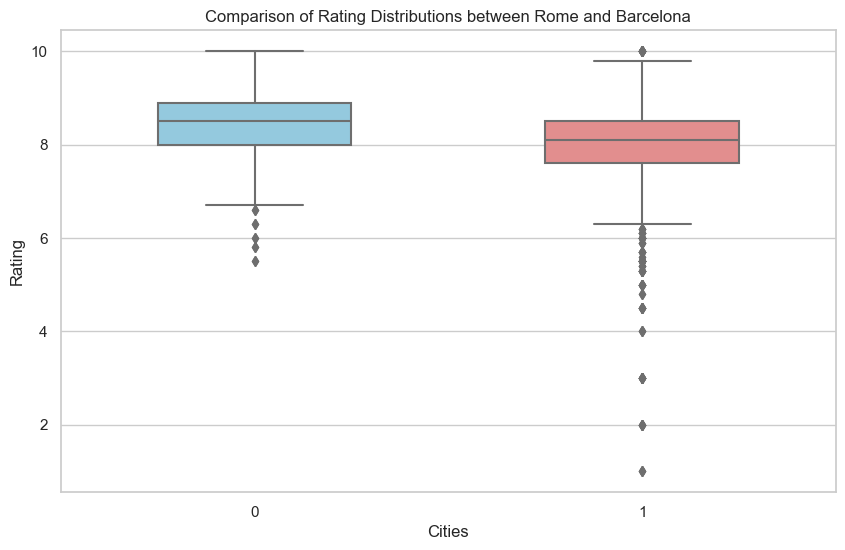

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a side-by-side boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[df_reg_r['rating'], df_reg_b['rating']], width=0.5, palette=["skyblue", "lightcoral"])

# Set labels and title
plt.xlabel('Cities')
plt.ylabel('Rating')
plt.title('Comparison of Rating Distributions between Rome and Barcelona')

# Show the plot
plt.show()

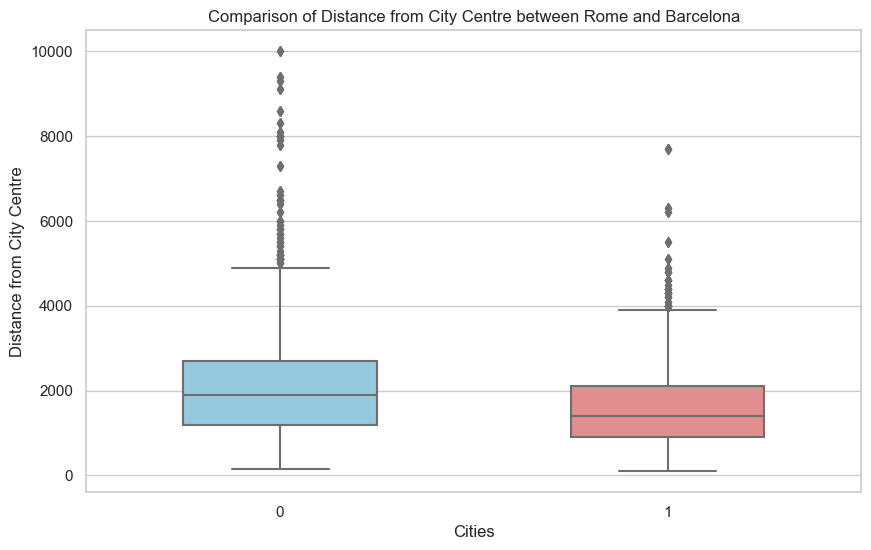

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a side-by-side boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[df_reg_r['distance_city_centre_meter'], df_reg_b['distance_city_centre_meter']], width=0.5, palette=["skyblue", "lightcoral"])

# Set labels and title
plt.xlabel('Cities')
plt.ylabel('Distance from City Centre')
plt.title('Comparison of Distance from City Centre between Rome and Barcelona')

# Show the plot
plt.show()

Already we can see some differences between the two cities and not the time period. For example, we see that 4% of hotels in our population have breakfast included in Barcelona whereas 20% of the hotels in Rome do. Free cancellation is also more common at 77% in Rome instead of 50% in Barcelona. Between both populations, "Few Left at this Price" is high with 95% in Rome and 74% in Barcelona. An interesting observation is that Barcelona has an 2.34 average total number of beds whereas Rome has an average of 1.56 meaning that on average hotels in Barcelona usually have one more bed available than hotels in Rome.

In [15]:
print(df_reg.columns)

Index(['price', 'rating', 'distance_city_centre_meter',
       'number_of_double_beds', 'number_of_single_beds', 'number_of_sofa_beds',
       'number_of_bunk_beds', 'total_number_of_beds', 'few_left_at_this_price',
       'free_cancellation', 'breakfast_included', 'timeperiod', 'city',
       'timeperiod_city_interaction'],
      dtype='object')


In [38]:
#make copy of the regression dataframe
#standardize the data for Lasso to give better coefficient estimates for feature selection
df_reg_scale = df_reg.copy()
y_ = df_reg_scale[['price']].copy()
df_reg_scale.drop(columns = ['price'], inplace = True)
feature_columns = list(df_reg_scale.columns)
scaler = StandardScaler()
scaler.fit(df_reg_scale)
df_reg_scale = scaler.transform(df_reg_scale)

# # create Lasso model for feature selection
feature_selection = LassoCV(cv = 5).fit(df_reg_scale, y_.values.ravel())

df_feature_coeff = pd.DataFrame(feature_selection.coef_, columns = ['Lasso Coefficient'], index = feature_columns)
df_feature_coeff['Lasso Coefficient Importance Scaled'] = (df_feature_coeff['Lasso Coefficient'].abs())/(df_feature_coeff['Lasso Coefficient'].abs().max())
df_feature_coeff.sort_values(by = ['Lasso Coefficient Importance Scaled'], ascending = [False], inplace = True)
df_feature_coeff.reset_index(inplace = True)
df_feature_coeff.rename(columns = {'index':'Feature'}, inplace = True)
print(df_feature_coeff.head())

df_feature_coeff.to_excel(path_out_reg_ + '\\' + 'Lasso Feature Importance.xlsx', index = False)


                       Feature  Lasso Coefficient  \
0         total_number_of_beds         473.627064   
1        number_of_double_beds         314.806519   
2   distance_city_centre_meter        -254.199722   
3  timeperiod_city_interaction         139.727296   
4                         city         134.586470   

   Lasso Coefficient Importance Scaled  
0                             1.000000  
1                             0.664672  
2                             0.536709  
3                             0.295015  
4                             0.284161  


Using LassoCV we use 5-fold cross validation to determine the best alpha parameter to use for a price prediction model. Taking the absolute values of the coefficients and dividing by the maximum, we calculate a feature importance metrics. The most important feature by far in predicting price appears to be 'Total Number of Beds' followed by 'Number of Double Beds' and 'Distance from City Centre'. For our fourth regression model, we will be including all three of these features to further analyze the price change in hotels from one week to the next with an event in Barcelona.

In [41]:
#model4-----------------------------

#Independent variables including the interaction term
X = df_reg[['timeperiod', 'city', 'timeperiod_city_interaction','total_number_of_beds','number_of_double_beds','distance_city_centre_meter']].copy()
y = df_reg['price'].copy()
#Initialize and fit the linear regression model
model4_features = LinearRegression()
model4_features.fit(X, y)
#Coefficients
intercept = model4_features.intercept_
coef_timeperiod, coef_city, coef_interaction, coef_total_beds, coef_double_beds, coef_dist = model4_features.coef_

list_coeff = [intercept, coef_timeperiod, coef_city, coef_interaction, coef_total_beds, coef_double_beds, coef_dist]
list_coeff_row = ['Intercept', 'Timeperiod', 'City', 'Interaction', 'Total Number of Beds', 'Number of Double Beds', 'Distance From City Centre']
df_model4 = pd.DataFrame(list_coeff, columns = ['Coefficient'], index = list_coeff_row)
df_model4.reset_index(inplace = True)
df_model4.rename(columns = {'index':'Parameter'}, inplace = True)
print(df_model4)
df_model4.to_excel(path_out_reg_ + '\\' + 'Model4 parameter values.xlsx', index = False)
# print(f"Model4 Coefficient for timeperiod: {coef_timeperiod_interaction.round(2)}, Coefficient for city: {coef_city_interaction.round(2)}, Coefficient for interaction: {coef_interaction.round(2)}, Intercept: {intercept_interaction.round(2)}")


                   Parameter  Coefficient
0                  Intercept   964.278740
1                 Timeperiod   -24.827301
2                       City   143.124614
3                Interaction   380.095868
4       Total Number of Beds   342.084583
5      Number of Double Beds   470.727212
6  Distance From City Centre    -0.200821


In [8]:
# look at significance

import statsmodels.api as sm

# Independent variables including the interaction term
X = df_reg[['timeperiod', 'city', 'timeperiod_city_interaction', 'total_number_of_beds', 'number_of_double_beds', 'distance_city_centre_meter']].copy()
X = sm.add_constant(X)  # Add a constant term to the independent variables matrix
y = df_reg['price'].copy()

# Initialize and fit the OLS model
model4_features = sm.OLS(y, X).fit()

# Display the summary
print(model4_features.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     311.5
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          2.15e-310
Time:                        17:20:34   Log-Likelihood:                -24607.
No. Observations:                2981   AIC:                         4.923e+04
Df Residuals:                    2974   BIC:                         4.927e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Due to the "Total Number of Beds" coefficients and the "Number of Double Beds" coefficeints being quite large, we can already see that the relationship of price between timeperiod and city has decreased.

To compare this model to model 3, we will assume "Total Number of Beds", "Number of Double Beds" and "Distance from City Centre" is zero.

With this model we see that the average price of a hotel stay in Rome the week before the Primavera sound event (in BCN) is approximately 964.28 and has a -24.82 decrease in price going into the next week for a 2.5% decrease in price from one week the the next. We see that the average price of a hotel stay in Barcelona the week before the Primavera sound event is approximately 1,107.40 (964.28 + 143.12) and increases by 380.10 in price for the week of the event resulting in a 34% price increase.

Previously we saw a 2% (-25.6/1461.50) decrease in price between the weeks in Rome and an 18% (355.1/(1461.50+501.05)) increase in price between the weeks in Barcelona. In this model we're seeing the same price change behavior between time period in Rome but for Barcelona we're seeing a more drastic price increase.

By adding in more feature variables, we're able to grasp a better understanding of price changes from one week to the next that is not attributable to number of beds or distance from the city. 

In this model we're seeing a more compelling argument (34% price increase instead of 18%) that during the week of the Primavera Sound event in Barcelona, hotel prices increase as compared to a similar european travel destination.

C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

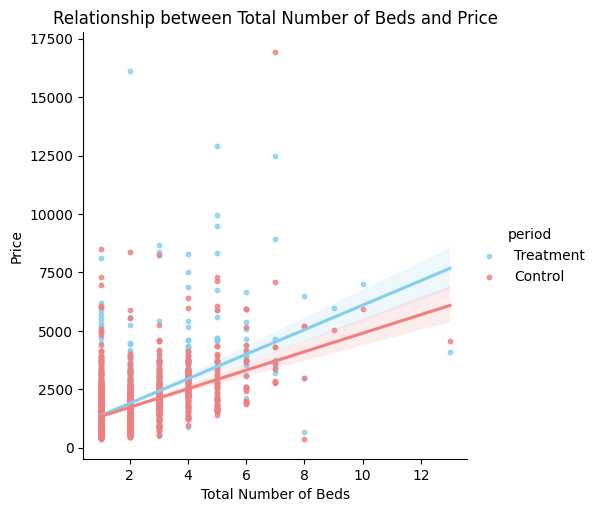

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the dataframes and add a 'period' column to differentiate between treatment and control
df_treat['period'] = 'Treatment'
df_control['period'] = 'Control'
combined_df = pd.concat([df_treat, df_control])

# Plot relationship between total_number_of_beds and price
plt.figure(figsize=(10, 6))
sns.lmplot(x='total_number_of_beds', y='price', data=combined_df, scatter_kws={'s': 10}, hue='period', palette=['skyblue', 'lightcoral'])

# Set labels and title
plt.xlabel('Total Number of Beds')
plt.ylabel('Price')
plt.title('Relationship between Total Number of Beds and Price')

plt.show()

C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

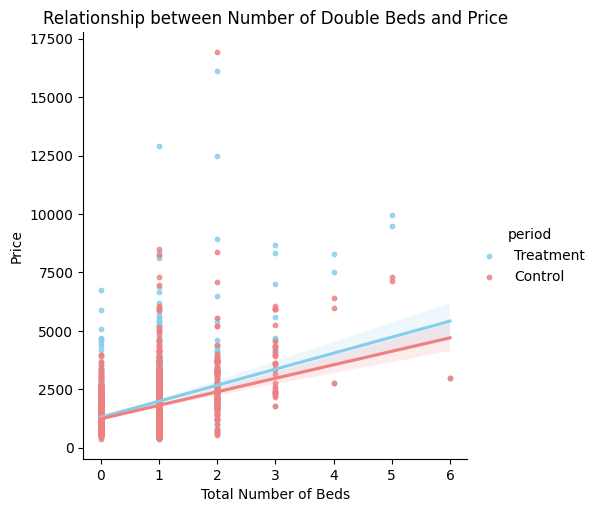

In [12]:
# show relatinship between number_of_double_beds and price
plt.figure(figsize=(10, 6))
sns.lmplot(x='number_of_double_beds', y='price', data=combined_df, scatter_kws={'s': 10}, hue='period', palette=['skyblue', 'lightcoral'])

# Set labels and title
plt.xlabel('Total Number of Beds')
plt.ylabel('Price')
plt.title('Relationship between Number of Double Beds and Price')

plt.show()

C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

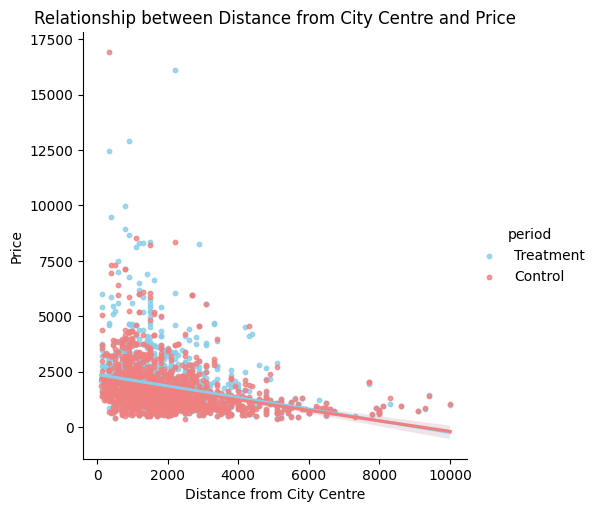

In [13]:
# show relatinship between number_of_double_beds and price
plt.figure(figsize=(10, 6))
sns.lmplot(x='distance_city_centre_meter', y='price', data=combined_df, scatter_kws={'s': 10}, hue='period', palette=['skyblue', 'lightcoral'])

# Set labels and title
plt.xlabel('Distance from City Centre')
plt.ylabel('Price')
plt.title('Relationship between Distance from City Centre and Price')

plt.show()